In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio
from tqdm import tqdm

In [2]:
def plot_img(img, ax, title=None):
    img = img.transpose(1, 2, 0).clip(0, 1)
    ax.imshow(img)
    ax.set_axis_off()
    if title:
        ax.set_title(title)

def plot_psnr_vs_lambda(path_results):

    with open(path_results, "rb") as f:
        list_results = pickle.load(f)
    
    names = [key for key in list_results[0].keys() if key.startswith("AD") or key.startswith("SD")]
    base_names = list(set([name.rsplit("_", 1)[0] for name in names]))
    base_names.sort()
    
    n_rep_list = list(set([int(name.split("_")[-1][:-1]) for name in names]))
    n_rep_list.sort()
    n_rep_list.remove(1)
    
    n_plots = len(base_names)
    n_img = len(list_results)

    fig_lambda, axs_lambda = plt.subplots(
        n_plots+1, n_img, sharey=True, figsize=(4*n_img, 3*(n_plots+1))
    )

    if (n_plots + 1 == 1) and (n_img == 1):
        axs_lambda = np.array([[axs_lambda]])
    elif n_plots + 1 == 1:
        axs_lambda = axs_lambda[np.newaxis, :]
    elif n_img == 1:
        axs_lambda = axs_lambda[:, np.newaxis]

    for i, results in enumerate(list_results):
        
        x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
        img = results["truth"].transpose(1, 2, 0).clip(0, 1)
        psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
        
        for k, base_name in enumerate(base_names):

            for rep in [1] + n_rep_list:
                
                name = f"{base_name}_{rep}R"
                res = results[name]
                axs_lambda[k, i].semilogx(res["lambda_list"], res['psnr'], label=rep)
            
            axs_lambda[k, i].set_title(f"{base_name}")
            axs_lambda[k, i].grid(True)
            axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
            axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
            axs_lambda[k, i].set_xlabel(rf"$\lambda$")
        
        name = "DRUNet"
        res = results[name]
        axs_lambda[-1, i].semilogx(res["lambda_list"], res['psnr'])
        axs_lambda[-1, i].set_title(f"{name}")
        axs_lambda[-1, i].grid(True)
        axs_lambda[-1, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
        axs_lambda[-1, i].set_xlabel(rf"$\lambda$")

    for ax in axs_lambda[:, 0]:
        ax.set_ylabel("PSNR (dB)")
    fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
    path_name = path_results.split(".")[0] + "_psnr_vs_lambda.pdf"
    fig_lambda.savefig(path_name, bbox_inches="tight")

def plot_error_vs_lambda(path_results):

    with open(path_results, "rb") as f:
        list_results = pickle.load(f)
    
    names = [key for key in list_results[0].keys() if key.startswith("AD") or key.startswith("SD")]
    base_names = list(set([name.rsplit("_", 1)[0] for name in names]))
    base_names.sort()
    
    n_rep_list = list(set([int(name.split("_")[-1][:-1]) for name in names]))
    n_rep_list.sort()
    n_rep_list.remove(1)
    
    n_plots = len(base_names)
    n_img = len(list_results)

    fig_lambda, axs_lambda = plt.subplots(
        n_plots, n_img, figsize=(4*n_img, 3*(n_plots))
    )

    if (n_plots == 1) and (n_img == 1):
        axs_lambda = np.array([[axs_lambda]])
    elif n_plots == 1:
        axs_lambda = axs_lambda[np.newaxis, :]
    elif n_img == 1:
        axs_lambda = axs_lambda[:, np.newaxis]

    for i, results in enumerate(list_results):
        
        x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
        img = results["truth"].transpose(1, 2, 0).clip(0, 1)
        
        for k, base_name in enumerate(base_names):

            for rep in [1] + n_rep_list:
                
                name = f"{base_name}_{rep}R"
                res = results[name]
                axs_lambda[k, i].semilogx(res["lambda_list"], res['error'], label=rep)
            
            axs_lambda[k, i].set_title(f"{base_name}")
            axs_lambda[k, i].grid(True)
            axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
            axs_lambda[k, i].set_xlabel(rf"$\lambda$")

    for ax in axs_lambda[:, 0]:
        ax.set_ylabel("Functional error")
    
    fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
    path_name = path_results.split(".")[0] + "_error_vs_lambda.pdf"
    fig_lambda.savefig(path_name, bbox_inches="tight")

def plot_psnr_vs_inner_lambda(path_results, idx=0, max_rows=3):
    
    with open(path_results, "rb") as f:
        list_results = pickle.load(f)
        
    names = [key for key in list_results[0].keys() if key.startswith("AD") or key.startswith("SD")] + ["DRUNet"]
    n_lambda = len(list_results[0]["DRUNet"]["lambda_list"])
    n_rows = min(len(names), max_rows)
    indices = np.random.choice(len(names), n_rows, replace=False)
    fig, axs = plt.subplots(n_rows, n_lambda, figsize=(4*n_lambda, 3.5*n_rows))

    for i in range(n_rows):
        axs[i, 0].set_ylabel(names[indices[i]])
        res = list_results[idx][names[indices[i]]]
        
        y_values = []  # Collect y-values for this row

        for j in range(n_lambda):
            y = res["psnr_inner"][res["stops"][j]:res["stops"][j+1]]
            axs[i, j].plot(y)
            axs[i, j].set_title(rf"$\lambda=${res['lambda_list'][j]:.2e}")
            y_values.extend(y)  # Gather for consistent y-axis
        
        # Set same y-limits for the entire row
        y_min, y_max = min(y_values), max(y_values)
        for j in range(n_lambda):
            axs[i, j].set_ylim(y_min, y_max)

    for ax in axs[:, 0]:
        ax.set_ylabel("PSNR (dB)")
    
    path_name = path_results.split(".")[0] + "_psnr_vs_inner_lambda.pdf"
    fig.savefig(path_name, bbox_inches="tight")

def plot_error_vs_inner_lambda(path_results, idx=0, max_rows=3):
    
    with open(path_results, "rb") as f:
        list_results = pickle.load(f)
        
    names = [key for key in list_results[0].keys() if key.startswith("AD") or key.startswith("SD")] + ["DRUNet"]
    n_lambda = len(list_results[0]["DRUNet"]["lambda_list"])
    n_rows = min(len(names), max_rows)
    indices = np.random.choice(len(names), n_rows, replace=False)
    fig, axs = plt.subplots(n_rows, n_lambda, figsize=(4*n_lambda, 3.5*n_rows))

    for i in range(n_rows):
        axs[i, 0].set_ylabel(names[indices[i]])
        res = list_results[idx][names[indices[i]]]
        
        y_values = []  # Collect y-values for this row

        for j in range(n_lambda):
            y = res["error_inner"][res["stops"][j]:res["stops"][j+1]]
            axs[i, j].plot(y)
            axs[i, j].set_title(rf"$\lambda=${res['lambda_list'][j]:.2e}")
            y_values.extend(y)  # Gather for consistent y-axis
        
        # Set same y-limits for the entire row
        y_min, y_max = min(y_values), max(y_values)
        for j in range(n_lambda):
            axs[i, j].set_ylim(y_min, y_max)

    for ax in axs[:, 0]:
        ax.set_ylabel("Functional error")

    path_name = path_results.split(".")[0] + "_error_vs_inner_lambda.pdf"
    fig.savefig(path_name, bbox_inches="tight")

def plot_best_psnr_vs_components(path_results):

    with open(path_results, "rb") as f:
        list_results = pickle.load(f)
    
    names = [key for key in list_results[0].keys() if key.startswith("AD") or key.startswith("SD")]
    components_list = list(set([int(name.split("_")[1][:-1]) for name in names]))
    components_list.sort()
    
    n_rep_list = list(set([int(name.split("_")[-1][:-1]) for name in names]))
    n_rep_list.sort()
    n_rep_list.remove(1)
    
    splitted_names = [name.split("_") for name in names]
    base_names = list(set([name[0]+"_"+name[2] for name in splitted_names]))
    base_names.sort()
    
    n_plots = len(base_names)
    n_img = len(list_results)

    fig_lambda, axs_lambda = plt.subplots(
        n_plots, n_img, sharey=True, figsize=(5*n_img, 4*(n_plots))
    )

    if (n_plots == 1) and (n_img == 1):
        axs_lambda = np.array([[axs_lambda]])
    elif n_plots == 1:
        axs_lambda = axs_lambda[np.newaxis, :]
    elif n_img == 1:
        axs_lambda = axs_lambda[:, np.newaxis]

    for i, results in enumerate(list_results):
        
        x_observed = results["observation"].transpose(1, 2, 0).clip(0, 1)
        img = results["truth"].transpose(1, 2, 0).clip(0, 1)
        psnr = peak_signal_noise_ratio(img, x_observed.astype(np.float32))
        
        for k, base_name in enumerate(base_names):
            
            pair_name = base_name.split("_")
            
            for rep in [1] + n_rep_list:
                
                denoiser_names = [pair_name[0]+f"_{components}C_"+pair_name[1]+f"_{rep}R" for components in components_list]
                psnr_list = [results[name]['best_psnr'] for name in denoiser_names]
                axs_lambda[k, i].scatter(components_list, psnr_list, label=rep, s=20)
                axs_lambda[k, i].set_xscale('log')
                axs_lambda[k, i].set_xticks(components_list)
                axs_lambda[k, i].set_xticklabels([str(val) for val in components_list])#, rotation=45)
            
            axs_lambda[k, i].set_title(f"{base_name}")
            axs_lambda[k, i].grid(True)
            axs_lambda[k, i].axhline(y=psnr, linestyle='--', alpha=0.5, color="grey")
            psnr_drunet = results["DRUNet"]['best_psnr']
            axs_lambda[k, i].axhline(y=psnr_drunet, linestyle='--', alpha=0.5, color="black")
            axs_lambda[k, i].legend(title="# iterations", fontsize=8, title_fontsize=8)
            axs_lambda[k, i].set_xlabel(f"# atoms")

    for ax in axs_lambda[:, 0]:
        ax.set_ylabel("PSNR (dB)")
    fig_lambda.tight_layout(rect=[0, 0, 1, 0.9])
    path_name = path_results.split(".")[0] + "_best_psnr_vs_components.pdf"
    fig_lambda.savefig(path_name, bbox_inches="tight")

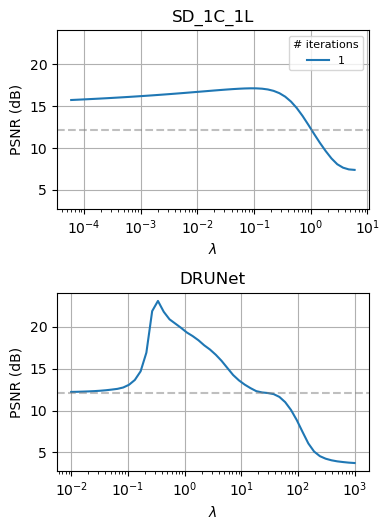

In [14]:
plot_psnr_vs_lambda("experiments/test_folder_bis/results.pkl")

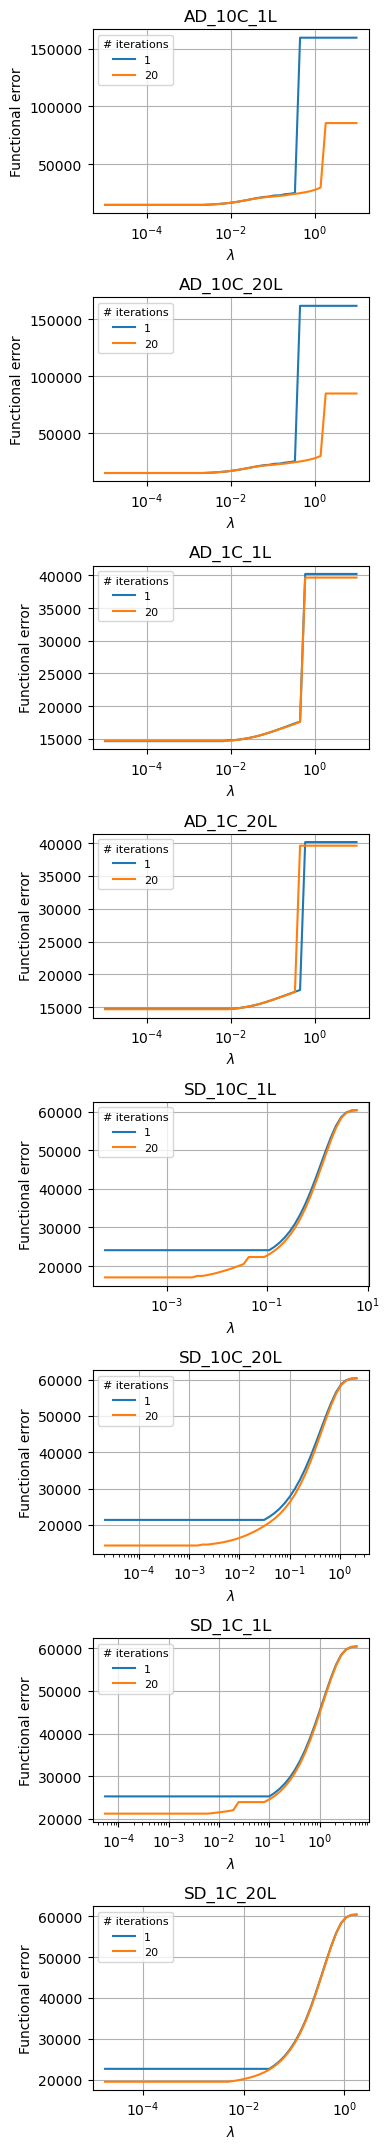

In [12]:
plot_error_vs_lambda("results_reproducibility1_blur.pkl")

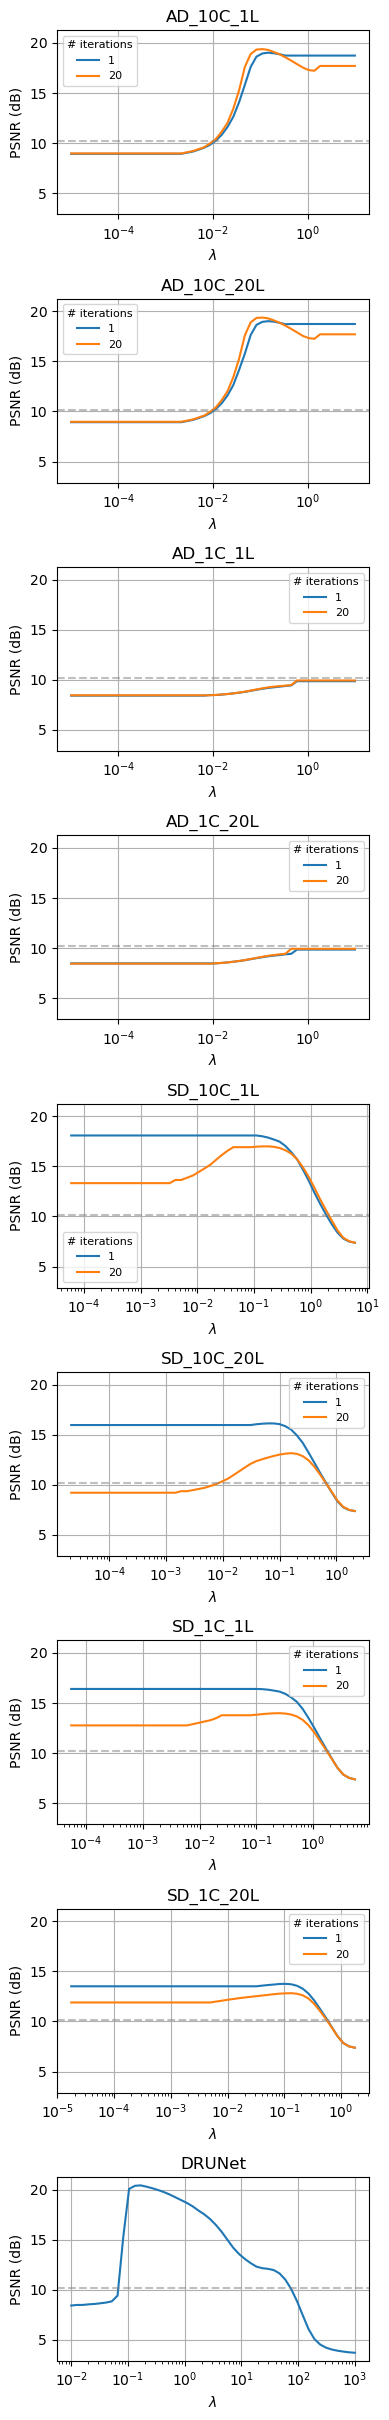

In [7]:
plot_psnr_vs_lambda("results_reproducibility1_blur.pkl")

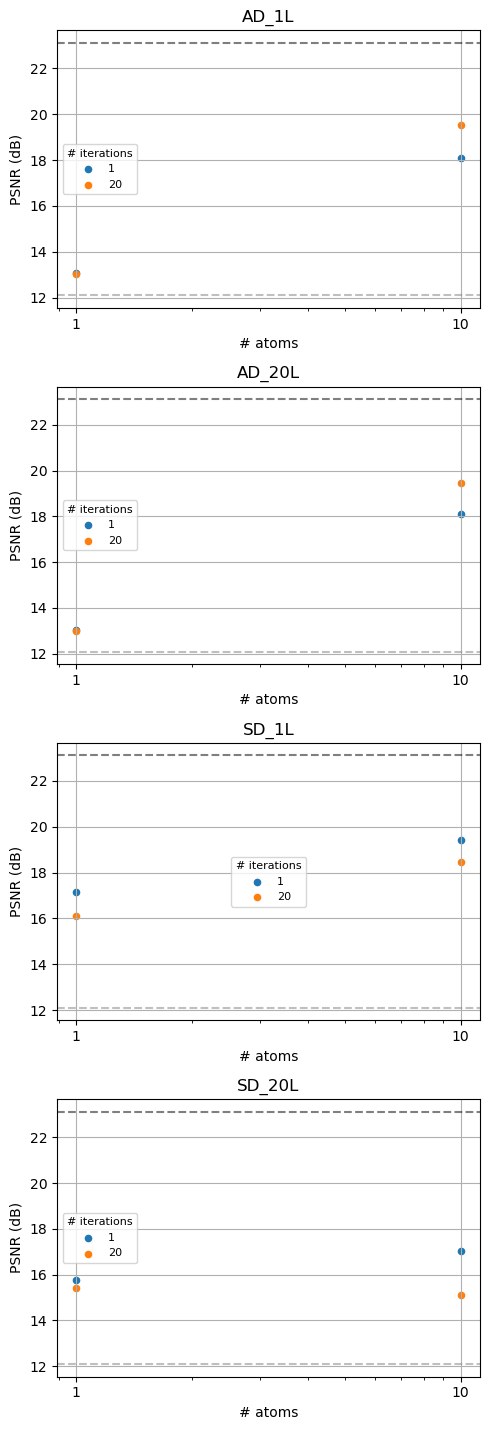

In [6]:
plot_best_psnr_vs_components("results_reproducibility2.pkl")

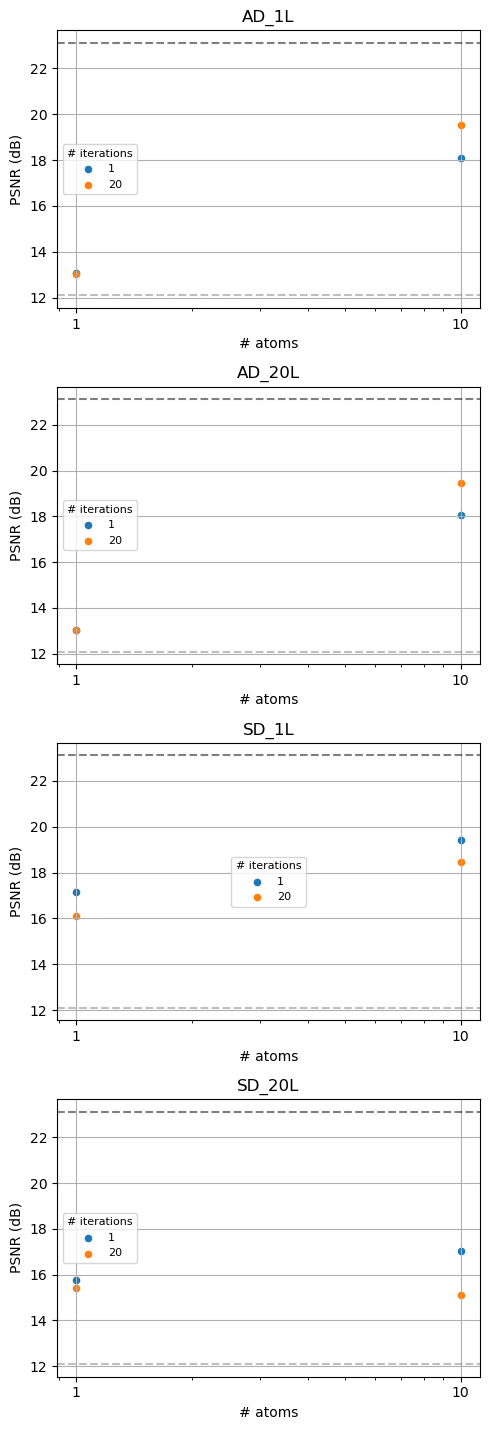

In [3]:
plot_best_psnr_vs_components("results_reproducibility1.pkl")

/tmp/ipykernel_88864/2670392950.py:181: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  axs[i, j].set_ylim(y_min, y_max)


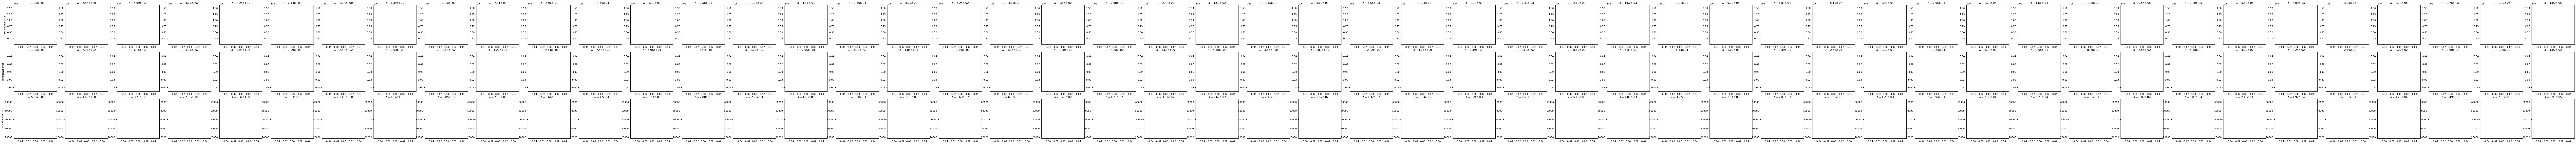

In [26]:
plot_error_vs_inner_lambda("results_reproducibility1.pkl")

[6 8 3]
SD_10C_20L_20R
AD_1C_1L_1R
SD_1C_20L_1R


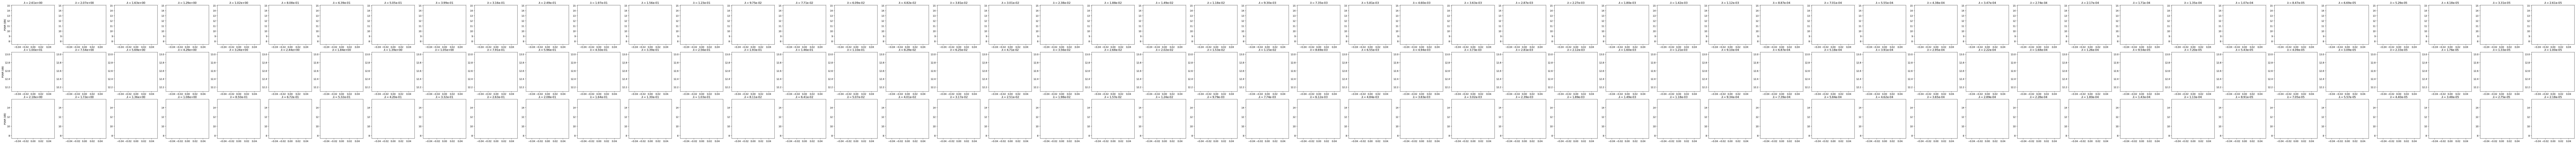

In [23]:
plot_psnr_vs_inner_lambda("results_reproducibility1.pkl")

In [6]:
with open("results_reproducibility1.pkl", "rb") as f:
    list_results1 = pickle.load(f)
with open("results_reproducibility2.pkl", "rb") as f:
    list_results2 = pickle.load(f)

In [12]:
list_results2[0]["SD_10C_1L_20R"]["best_img_psnr"][0,:3,:3]

array([[0.41621444, 0.700124  , 0.7744918 ],
       [0.28008854, 0.6416569 , 1.        ],
       [0.78384614, 0.91012657, 0.93996644]], dtype=float32)

In [13]:
list_results1[0]["SD_10C_1L_20R"]["best_img_psnr"][0,:3,:3]

array([[0.41621444, 0.7001241 , 0.7744918 ],
       [0.28008854, 0.6416568 , 1.        ],
       [0.78384614, 0.91012657, 0.93996644]], dtype=float32)

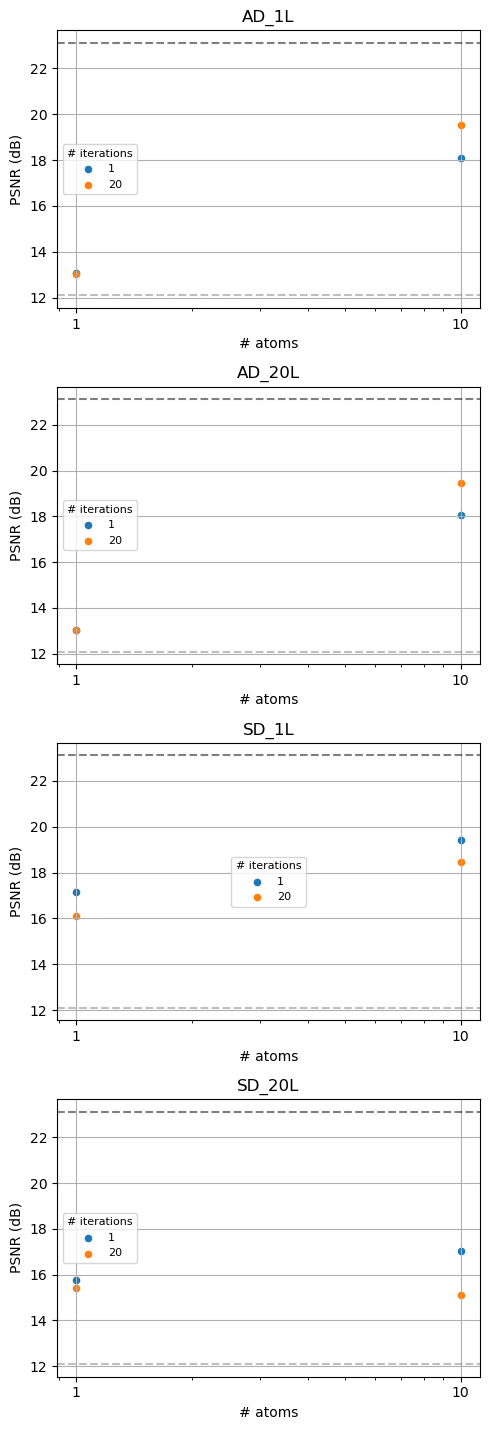

In [4]:
plot_best_psnr_vs_components("results_reproducibility1.pkl")

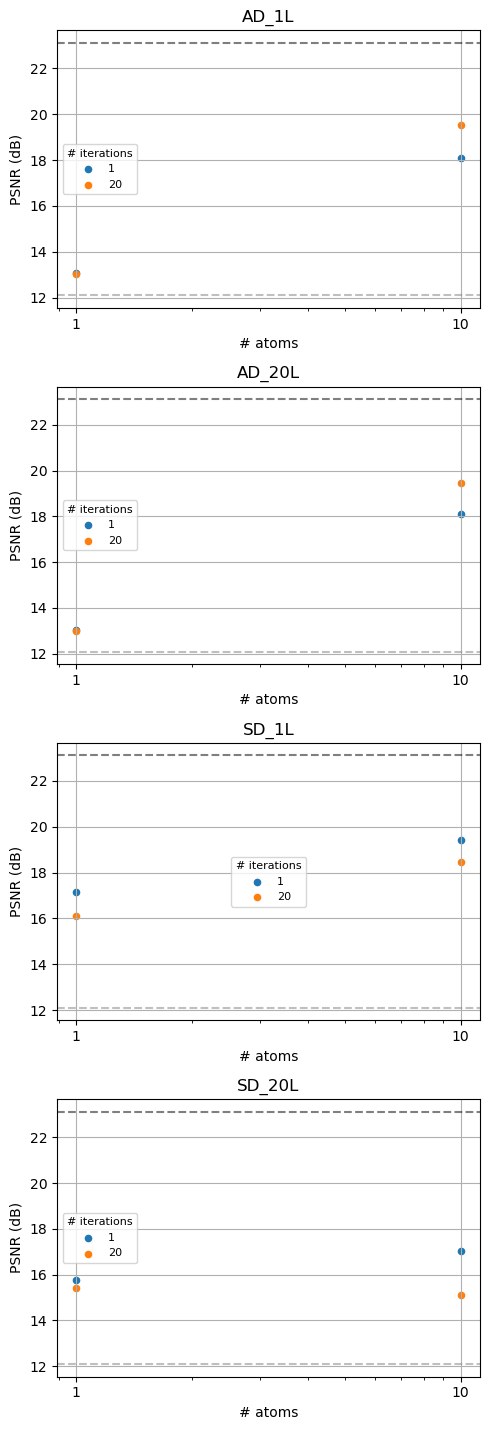

In [5]:
plot_best_psnr_vs_components("results_reproducibility2.pkl")

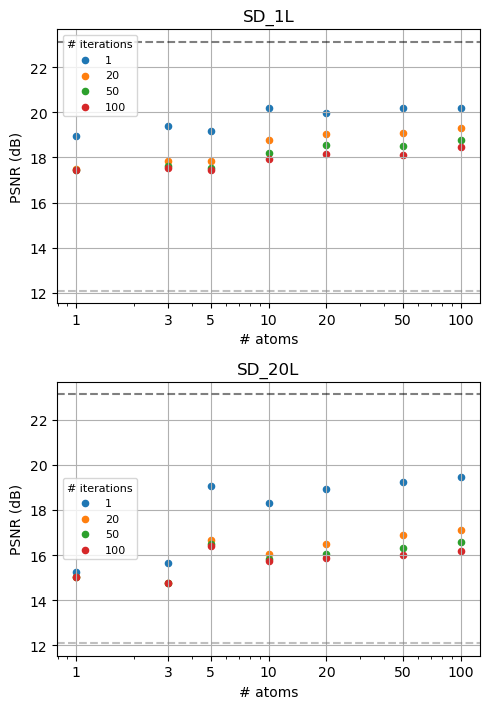

In [90]:
plot_best_psnr_vs_components("results_denoising_03.pkl")

In [33]:
names = [key for key in list_results[0].keys() if key.startswith("AD") or key.startswith("SD")]

In [37]:
[name.split("_")[2][:-1] for name in names]

['1', '1', '1', '7', '7', '7', '1', '1', '1', '7', '7', '7']

In [ ]:
n_rep_list = list(set([int(name.split("_")[-1][:-1]) for name in names]))

In [34]:
names

['SD_3C_1L_1R',
 'SD_3C_1L_7R',
 'SD_3C_1L_69R',
 'SD_3C_7L_7R',
 'SD_3C_7L_1R',
 'SD_3C_7L_69R',
 'SD_42C_1L_1R',
 'SD_42C_1L_7R',
 'SD_42C_1L_69R',
 'SD_42C_7L_7R',
 'SD_42C_7L_1R',
 'SD_42C_7L_69R']

In [ ]:
base_names = list(set([name.rsplit("_", 1)[0] for name in names]))
base_names.sort()

In [ ]:
path = "results_denoising_03_more_iterations.pkl"
plot_psnr_vs_lambda(path)
plot_error_vs_lambda(path)
plot_psnr_vs_inner_lambda(path)
plot_error_vs_inner_lambda(path)

In [3]:
with open("results_denoising_03.pkl", "rb") as f:
    list_results = pickle.load(f)

In [14]:
list_results[0]["DRUNet"].keys()

dict_keys(['img', 'cvg', 'psnr', 'error', 'time', 'lambda_list', 'psnr_inner', 'error_inner', 'stops', 'best_img_psnr', 'best_img_error', 'best_psnr', 'best_error', 'best_lambda'])

Best lambda: 0.33932217718953295, Best error: 0


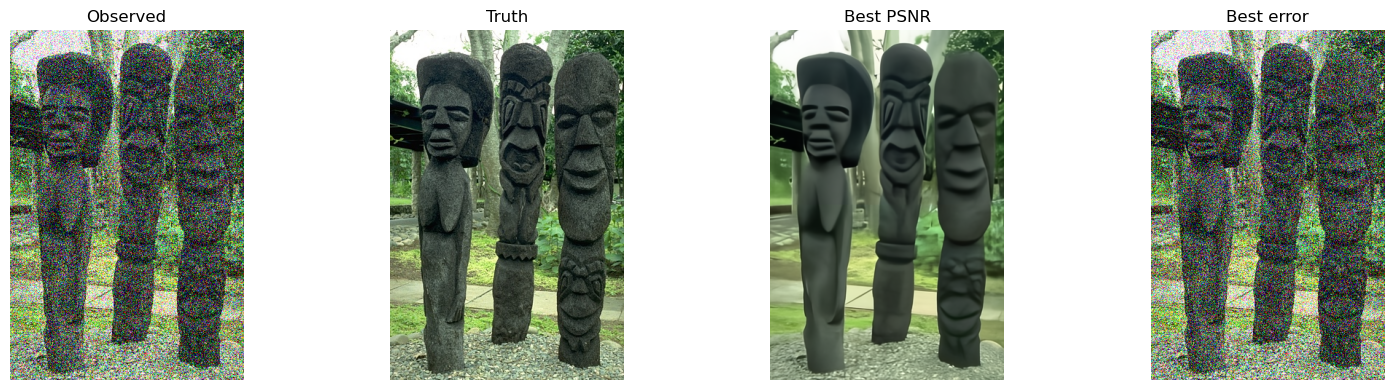

In [64]:
# Show 4 images side by side
denoiser = "DRUNet"
img_observed = list_results[0]["observation"]
img_truth = list_results[0]["truth"]
best_img_psnr = list_results[0][denoiser]["best_img_psnr"]
best_img_error = list_results[0][denoiser]["best_img_error"]
best_lambda = list_results[0][denoiser]["best_lambda"]
best_error = list_results[0][denoiser]["best_error"]
print(f"Best lambda: {best_lambda}, Best error: {best_error}")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
plot_img(img_observed, axs[0], title="Observed")
plot_img(img_truth, axs[1], title="Truth")
plot_img(best_img_psnr, axs[2], title="Best PSNR")
plot_img(best_img_error, axs[3], title="Best error")
plt.tight_layout()
plt.show()

Best lambda: 0.03926625938788364, Best error: 0


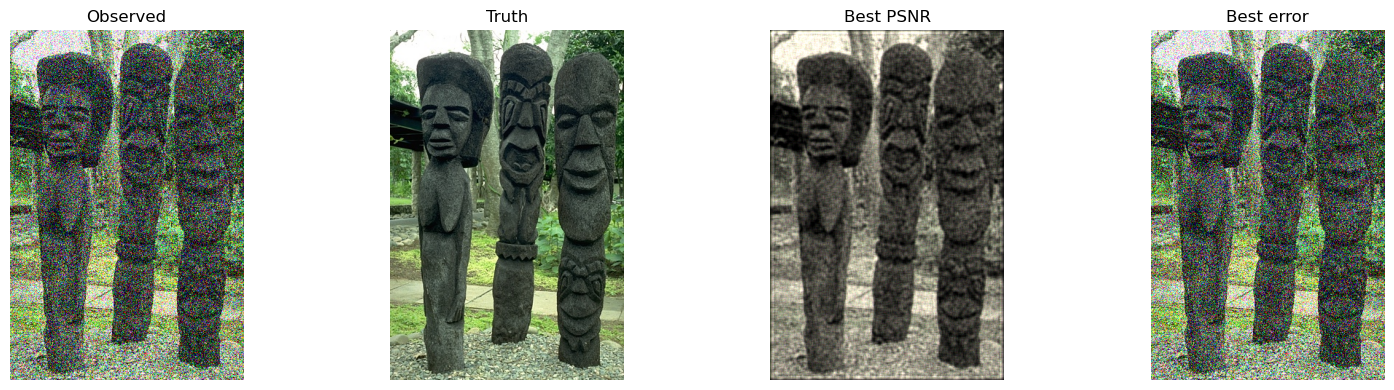

In [63]:
# Show 4 images side by side
denoiser = "SD_50C_1L_1R"
img_observed = list_results[0]["observation"]
img_truth = list_results[0]["truth"]
best_img_psnr = list_results[0][denoiser]["best_img_psnr"]
best_img_error = list_results[0][denoiser]["best_img_error"]
best_lambda = list_results[0][denoiser]["best_lambda"]
best_error = list_results[0][denoiser]["best_error"]
print(f"Best lambda: {best_lambda}, Best error: {best_error}")

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
plot_img(img_observed, axs[0], title="Observed")
plot_img(img_truth, axs[1], title="Truth")
plot_img(best_img_psnr, axs[2], title="Best PSNR")
plot_img(best_img_error, axs[3], title="Best error")
plt.tight_layout()
plt.show()

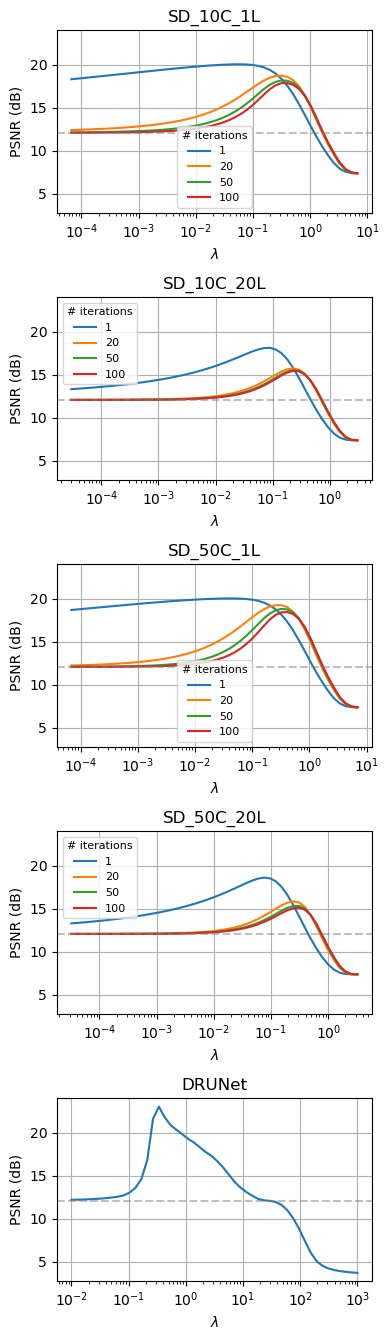

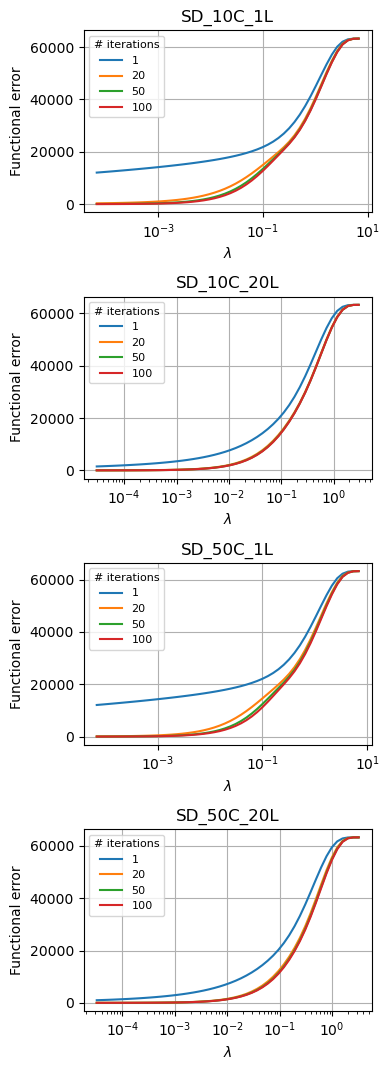

In [60]:
results_path = "results_denoising_03.pkl"

plot_psnr_vs_lambda(results_path)
plot_error_vs_lambda(results_path)